# Imports

First, we begin by making imports to important libraries that will be used throughout the entire program.

In [ ]:
from bs4 import BeautifulSoup
from collections import Counter
from collections import defaultdict
from datetime import datetime

import math
import numpy as np
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import requests 

!pip install pgeocode
import pgeocode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Collection and Conversion

We load up the Excel sheets provided by B&B on transactions/orders into a dataframe called data data. We load up each Excel sheet into an individual dataframe and then combine those dataframes. Through some intermediate work (which is explained throughout), we convert the data dataframe whose entries are transactions into the customer dataframe whose entries the customers. 

In [ ]:
%%time

data = []

for file in os.listdir():
    if file.endswith(".xlsx"):
        data.append(pd.read_excel(file))

CPU times: user 1min 43s, sys: 682 ms, total: 1min 44s
Wall time: 1min 52s


In [ ]:
data = pd.concat(data, axis=0, ignore_index=True)

We begin by removing the transactions/orders whose order total was greater than 700 dollars or less than 0 dollars, this is to remove any mistakes, outliers, or orders which may have been made by restaurants. Additionally, we remove any entries whose email was null because we can't do much with those entries.

In [ ]:
data = data.loc[(data['Total'] < 700) & (data['Total'] > 0) & (data['Email'].isnull() == False)]

In [ ]:
data = data.loc[data['Shipping Country'] == 'US']

In [ ]:
data

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Lineitem fulfillment status,Billing City,Billing Zip,Billing Province,Billing Country,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Cancelled at
0,93689,1459.0,paid,2021-07-11 14:46:00,fulfilled,2021-07-12 20:49:00,yes,USD,54.94,0.00,...,fulfilled,Sylvania,'43560,OH,US,Sylvania,'43560,OH,US,NaT
4,93688,1460.0,paid,2021-07-11 14:46:00,fulfilled,2021-07-12 20:49:00,no,USD,101.95,0.00,...,fulfilled,Blaine,'98230,WA,US,Blaine,'98230,WA,US,NaT
9,93687,1461.0,paid,2021-07-11 14:44:00,fulfilled,2021-07-12 20:49:00,yes,USD,50.96,0.00,...,fulfilled,greer,'29650,SC,US,greer,'29650,SC,US,NaT
13,93686,1462.0,paid,2021-07-11 14:43:00,fulfilled,2021-07-12 20:49:00,yes,USD,55.94,0.00,...,fulfilled,Seattle,98103-7663,WA,US,Seattle,98103-7663,WA,US,NaT
16,93685,1463.0,paid,2021-07-11 14:42:00,fulfilled,2021-07-12 20:50:00,no,USD,28.97,5.99,...,fulfilled,Toppenish,'98948,WA,US,Toppenish,'98948,WA,US,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394630,148921,15380.0,paid,2022-04-07 06:25:00,fulfilled,2022-04-07 19:07:00,yes,USD,52.99,0.00,...,fulfilled,Clinton,'37716,TN,US,Lancaster,'17601,PA,US,NaT
394631,148920,18883.0,paid,2022-04-07 04:02:00,fulfilled,2022-04-07 19:07:00,yes,USD,39.99,7.99,...,fulfilled,Westbury,'11590,NY,US,Westbury,'11590,NY,US,NaT
394632,148919,18884.0,paid,2022-04-07 03:00:00,fulfilled,2022-04-07 19:08:00,yes,USD,32.98,7.99,...,fulfilled,Arcadia,'91007,CA,US,Arcadia,'91007,CA,US,NaT
394633,148918,18885.0,paid,2022-04-07 01:44:00,fulfilled,2022-04-09 19:11:00,yes,USD,23.98,7.99,...,fulfilled,Oakland,'94602,CA,US,Oakland,'94602,CA,US,NaT


We create several dictionaries where the keys would be emails and the values would be the variable associated to that email. For example, the order_frequency dictionary's keys are the emails and the values are that email's order frequency. These dictionaries are filled while iterating through the data dataframe. After these dictionaries are filled, parallel lists are created which eventually become the columns of the customer dataframe. 

In [ ]:
order_frequency = defaultdict(int)
disc_usage = defaultdict(int)
spice_club = {}
free_shipping_usage = defaultdict(int)
total = defaultdict(int)
zip = {}
city = {} 
state = {}

for index, row in data.iterrows():
  order_frequency[row['Email']] += 1
  if (row['Discount Amount'] > 0):
    disc_usage[row['Email']] += 1
  else:
    disc_usage[row['Email']] += 0
  spice_club[row['Email']] = row['Accepts Marketing']
  if (row['Shipping'] == 0):
    free_shipping_usage[row['Email']] += 1
  else: 
    free_shipping_usage[row['Email']] += 0
  total[row['Email']] += row['Total']
  zip[row['Email']] = row['Shipping Zip']
  city[row['Email']] = row['Shipping City']
  state[row['Email']] = row['Shipping Province']

email_col = []
order_frequency_col = []
disc_usage_col = []
spice_club_col = []
free_shipping_usage_col = [] 
total_col = []
zip_col = []
city_col = []
state_col = []

for i in data['Email'].unique():
  email_col.append(i)
  order_frequency_col.append(order_frequency[i])
  disc_usage_col.append(disc_usage[i])
  spice_club_col.append(spice_club[i])
  free_shipping_usage_col.append(free_shipping_usage[i])
  total_col.append(total[i])
  zip_col.append(zip[i])
  city_col.append(city[i])
  state_col.append(state[i])

customer = pd.DataFrame({"Email" : email_col, "Order Frequency" : order_frequency_col, "Discount Usage": disc_usage_col,
                         "Spice Club" : spice_club_col, "Free Shipping Usage" : free_shipping_usage_col, 
                         "Total" : total_col, "Zip Code" : zip_col, "City" : city_col, "State" : state_col,})

We fix the zip code column in the customer dataframe by reformatting the entries which don't match the standard 5 digit format. 

In [ ]:
fixed_zips = [] 

for index, row in customer.iterrows():
  correct = str(row['Zip Code'])
  if (correct[0] == "'"):
    correct = correct[1:]
  if ("-" in correct):
    correct = correct[0:5]
  fixed_zips.append(correct)

customer['Zip Code'] = fixed_zips

We fix the cities column in the customer dataframe so they are all in the standard title case.

In [ ]:
fixed_cities = [] 

for index, row in customer.iterrows():
  correct = ""
  correct += str(row['City'])
  correct = correct.title()
  fixed_cities.append(correct)

customer['City'] = fixed_cities

We import a list of city names, found on Github. We then iterate through the customer dataframe and if the entry's shipping city is in the list of city names then a new column called "Metro Index" (which indicates if the customer is in a metropolitan area) is filled in to be "Metro" otherwise it is filled in to be "Non-Metro". 

In [ ]:
city_names = ["Aberdeen", "Abilene", "Akron", "Albany", "Albuquerque", "Alexandria", "Allentown", "Amarillo", "Anaheim", "Anchorage", "Ann Arbor", "Antioch", "Apple Valley", "Appleton", "Arlington", "Arvada", "Asheville", "Athens", "Atlanta", "Atlantic City", "Augusta", "Aurora", "Austin", "Bakersfield", "Baltimore", "Barnstable", "Baton Rouge", "Beaumont", "Bel Air", "Bellevue", "Berkeley", "Bethlehem", "Billings", "Birmingham", "Bloomington", "Boise", "Boise City", "Bonita Springs", "Boston", "Boulder", "Bradenton", "Bremerton", "Bridgeport", "Brighton", "Brownsville", "Bryan", "Buffalo", "Burbank", "Burlington", "Cambridge", "Canton", "Cape Coral", "Carrollton", "Cary", "Cathedral City", "Cedar Rapids", "Champaign", "Chandler", "Charleston", "Charlotte", "Chattanooga", "Chesapeake", "Chicago", "Chula Vista", "Cincinnati", "Clarke County", "Clarksville", "Clearwater", "Cleveland", "College Station", "Colorado Springs", "Columbia", "Columbus", "Concord", "Coral Springs", "Corona", "Corpus Christi", "Costa Mesa", "Dallas", "Daly City", "Danbury", "Davenport", "Davidson County", "Dayton", "Daytona Beach", "Deltona", "Denton", "Denver", "Des Moines", "Detroit", "Downey", "Duluth", "Durham", "El Monte", "El Paso", "Elizabeth", "Elk Grove", "Elkhart", "Erie", "Escondido", "Eugene", "Evansville", "Fairfield", "Fargo", "Fayetteville", "Fitchburg", "Flint", "Fontana", "Fort Collins", "Fort Lauderdale", "Fort Smith", "Fort Walton Beach", "Fort Wayne", "Fort Worth", "Frederick", "Fremont", "Fresno", "Fullerton", "Gainesville", "Garden Grove", "Garland", "Gastonia", "Gilbert", "Glendale", "Grand Prairie", "Grand Rapids", "Grayslake", "Green Bay", "GreenBay", "Greensboro", "Greenville", "Gulfport-Biloxi", "Hagerstown", "Hampton", "Harlingen", "Harrisburg", "Hartford", "Havre de Grace", "Hayward", "Hemet", "Henderson", "Hesperia", "Hialeah", "Hickory", "High Point", "Hollywood", "Honolulu", "Houma", "Houston", "Howell", "Huntington", "Huntington Beach", "Huntsville", "Independence", "Indianapolis", "Inglewood", "Irvine", "Irving", "Jackson", "Jacksonville", "Jefferson", "Jersey City", "Johnson City", "Joliet", "Kailua", "Kalamazoo", "Kaneohe", "Kansas City", "Kennewick", "Kenosha", "Killeen", "Kissimmee", "Knoxville", "Lacey", "Lafayette", "Lake Charles", "Lakeland", "Lakewood", "Lancaster", "Lansing", "Laredo", "Las Cruces", "Las Vegas", "Layton", "Leominster", "Lewisville", "Lexington", "Lincoln", "Little Rock", "Long Beach", "Lorain", "Los Angeles", "Louisville", "Lowell", "Lubbock", "Macon", "Madison", "Manchester", "Marina", "Marysville", "McAllen", "McHenry", "Medford", "Melbourne", "Memphis", "Merced", "Mesa", "Mesquite", "Miami", "Milwaukee", "Minneapolis", "Miramar", "Mission Viejo", "Mobile", "Modesto", "Monroe", "Monterey", "Montgomery", "Moreno Valley", "Murfreesboro", "Murrieta", "Muskegon", "Myrtle Beach", "Naperville", "Naples", "Nashua", "Nashville", "New Bedford", "New Haven", "New London", "New Orleans", "New York", "New York City", "Newark", "Newburgh", "Newport News", "Norfolk", "Normal", "Norman", "North Charleston", "North Las Vegas", "North Port", "Norwalk", "Norwich", "Oakland", "Ocala", "Oceanside", "Odessa", "Ogden", "Oklahoma City", "Olathe", "Olympia", "Omaha", "Ontario", "Orange", "Orem", "Orlando", "Overland Park", "Oxnard", "Palm Bay", "Palm Springs", "Palmdale", "Panama City", "Pasadena", "Paterson", "Pembroke Pines", "Pensacola", "Peoria", "Philadelphia", "Phoenix", "Pittsburgh", "Plano", "Pomona", "Pompano Beach", "Port Arthur", "Port Orange", "Port Saint Lucie", "Port St. Lucie", "Portland", "Portsmouth", "Poughkeepsie", "Providence", "Provo", "Pueblo", "Punta Gorda", "Racine", "Raleigh", "Rancho Cucamonga", "Reading", "Redding", "Reno", "Richland", "Richmond", "Richmond County", "Riverside", "Roanoke", "Rochester", "Rockford", "Roseville", "Round Lake Beach", "Sacramento", "Saginaw", "Saint Louis", "Saint Paul", "Saint Petersburg", "Salem", "Salinas", "Salt Lake City", "San Antonio", "San Bernardino", "San Buenaventura", "San Diego", "San Francisco", "San Jose", "Santa Ana", "Santa Barbara", "Santa Clara", "Santa Clarita", "Santa Cruz", "Santa Maria", "Santa Rosa", "Sarasota", "Savannah", "Scottsdale", "Scranton", "Seaside", "Seattle", "Sebastian", "Shreveport", "Simi Valley", "Sioux City", "Sioux Falls", "South Bend", "South Lyon", "Spartanburg", "Spokane", "Springdale", "Springfield", "St. Louis", "St. Paul", "St. Petersburg", "Stamford", "Sterling Heights", "Stockton", "Sunnyvale", "Syracuse", "Tacoma", "Tallahassee", "Tampa", "Temecula", "Tempe", "Thornton", "Thousand Oaks", "Toledo", "Topeka", "Torrance", "Trenton", "Tucson", "Tulsa", "Tuscaloosa", "Tyler", "Utica", "Vallejo", "Vancouver", "Vero Beach", "Victorville", "Virginia Beach", "Visalia", "Waco", "Warren", "Washington", "Waterbury", "Waterloo", "West Covina", "West Valley City", "Westminster", "Wichita", "Wilmington", "Winston", "Winter Haven", "Worcester", "Yakima", "Yonkers", "York", "Youngstown"]
metro_idx = [] 

for index, row in customer.iterrows():
  if row['City'] in city_names:
    metro_idx.append('Metro')
  else:
    metro_idx.append('Non-Metro')

customer['Metro Index'] = metro_idx

We convert all of the yes in the "Spice Club" and "Metro Index" column to 1 and 0 otherwise. We then modify the "Spice Club" column to be "In Spice Club" and the "Metro Index" column to be "In Metro Area" column.

In [ ]:
in_spice_club = []
in_metro_area = []

for index, row in customer.iterrows():
  if (row['Spice Club'] == 'yes'):
    in_spice_club.append(1)
  else:
    in_spice_club.append(0)
    
  if (row['Metro Index'] == 'Metro'):
    in_metro_area.append(1)
  else:
    in_metro_area.append(0)

customer['Spice Club'] = in_spice_club
customer['Metro Index'] = in_metro_area

customer = customer.rename(columns={'Spice Club': 'In Spice Club', 'Metro Index': 'In Metro Area'})

In [ ]:
customer

,Email,Order Frequency,Discount Usage,In Spice Club,Free Shipping Usage,Total,Zip Code,City,State,In Metro Area
0,1459.0,2,0,1,1,87.90,43560,Sylvania,OH,0
1,1460.0,9,1,1,8,794.77,98230,Blaine,WA,0
2,1461.0,21,1,1,19,980.51,29650,Greer,SC,0
3,1462.0,18,1,1,17,1294.04,98103,Seattle,WA,1
4,1463.0,5,0,0,2,195.61,98948,Toppenish,WA,0
...,...,...,...,...,...,...,...,...,...,...
51371,18878.0,1,0,1,1,67.93,78666,San Marcos,TX,0
51372,18880.0,1,0,0,1,45.00,44663,New Philadelphia,OH,0
51373,18881.0,1,0,0,0,18.23,20176,Leesburg,VA,0
51374,18882.0,1,0,1,1,127.99,18901,Doylestown,PA,0


# Answering: How do customers cluster into one-time vs. repeat customers?

We created a few plots which described the clustering of one-time and repeat customers. 

We plot a histogram of the order frequencies, a column in the customer dataframe.

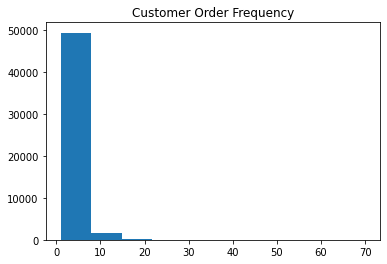

In [ ]:
plt.hist(customer['Order Frequency'])
plt.title('Customer Order Frequency')
plt.show()

We plot a box plot of the order frequencies, a column in the customer dataframe.

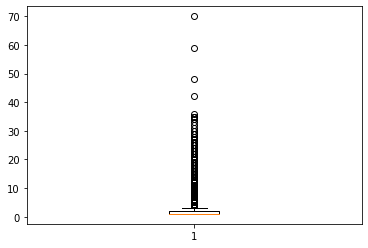

In [ ]:
plt.boxplot(customer['Order Frequency'])
plt.show()

We plot a bar graph where one of the bars is the count of customers whose count was 1, while the other bar is the count of customers who count was not one.

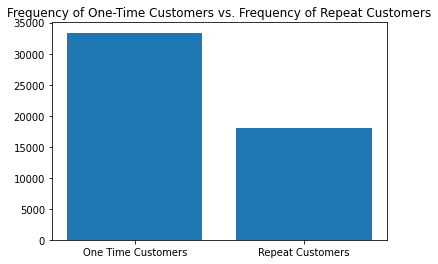

In [ ]:
one_time_count = customer['Order Frequency'].value_counts()[1]
repeat_count = len(customer['Order Frequency']) - one_time_count
groups = ['One Time Customers', 'Repeat Customers']
counts = [one_time_count,repeat_count]
plt.bar(groups,counts)
plt.title('Frequency of One-Time Customers vs. Frequency of Repeat Customers')
plt.show()

In [ ]:
one_time_count

33378

In [ ]:
repeat_count

17998

# Answering: How long after a first purchase does a customer typically make a second purchase? 

We create a new column in the customer dataframe which represents the time delta between a customer's first and second order, we set all of the entries whose time delta was less than 3 to have a short-term delta in the short-time delta column.

We create a dictionary, customer_dates, whose key is a the customer's email and the value is a list of times the customer made orders. 

In [ ]:
customer_dates = defaultdict(list)

for index, row in data.iterrows():
  customer_dates[row['Email']].append(row['Paid at'])

We create a new dictionary, customer_time_delta, which holds the difference in time between a customer's first and second purchase aka time delta. We then create a function (daysdiff) which finds the number of days between two datetime objects. Finally, we iterate through the customer_dates dictionary mentioned. If a customer has more than one date, then we find the difference between those two dates using the daysdiff function and set it to the customer's value in the customer_time_delta, otherwise we the customer's value in the customer_time_delta to be 1000 (which is basically a NaN).

In [ ]:
import sys 

customer_time_delta = {}

sum = 0
elements = 0

def daysdiff(a, b):
  return abs((a.to_pydatetime() - b.to_pydatetime()).days)

for key in customer_dates:
  if (len(customer_dates[key]) > 1):
    delta = daysdiff(customer_dates[key][0], customer_dates[key][1])
    customer_time_delta[key] = delta
    sum += delta
    elements += 1
  else:
    customer_time_delta[key] = 1000

We iterate through the customer_time_delta dictionary and fill in dataframe with each customer's time delta. 

In [ ]:
delta = [] 

for index, row in customer.iterrows():
  delta.append(customer_time_delta[row['Email']])

In [ ]:
customer['Time Delta'] = delta
customer

,Email,Order Frequency,Discount Usage,In Spice Club,Free Shipping Usage,Total,Zip Code,City,State,In Metro Area,Time Delta
0,1459.0,2,0,1,1,87.90,43560,Sylvania,OH,0,132.0
1,1460.0,9,1,1,8,794.77,98230,Blaine,WA,0,54.0
2,1461.0,21,1,1,19,980.51,29650,Greer,SC,0,40.0
3,1462.0,18,1,1,17,1294.04,98103,Seattle,WA,1,14.0
4,1463.0,5,0,0,2,195.61,98948,Toppenish,WA,0,120.0
...,...,...,...,...,...,...,...,...,...,...,...
51371,18878.0,1,0,1,1,67.93,78666,San Marcos,TX,0,1000.0
51372,18880.0,1,0,0,1,45.00,44663,New Philadelphia,OH,0,1000.0
51373,18881.0,1,0,0,0,18.23,20176,Leesburg,VA,0,1000.0
51374,18882.0,1,0,1,1,127.99,18901,Doylestown,PA,0,1000.0


In [ ]:
customer['Time Delta'] =  customer['Time Delta'].fillna(1000)

We create a new list called exist_time_delta which contains the time delta of all the customers who placed more than one order, which is the customer's whose time delta was not 1000. We chose 100 because it's not possible for any customer to have a time delta of 1000 because this dataset only consisted of two years. We then find the summary stats of this new list by converting the list to a Series and using the .describe() function on the series. 

In [ ]:
exist_time_delta = []

for index, row in customer.iterrows():
  if (row['Time Delta'] != 1000):
    exist_time_delta.append(row['Time Delta'])

exist_time_delta = pd.Series(exist_time_delta)
exist_time_delta.describe()

count    17785.000000
mean       146.315772
std        128.932284
min          0.000000
25%         40.000000
50%        107.000000
75%        223.000000
max        599.000000
dtype: float64

We create a new column called "Short Time Delta" which contains whether or not the customer's time delta exceeded 92 days (or three months). We iterare through the dataframe checking if each entries' time delta exceeded 92 days. If it did, the new column's value is 1 otherwise it's 0. 

In [ ]:
short_time_delta = []

for index, row in customer.iterrows():
  if (row['Time Delta'] <= 92):
    short_time_delta.append(1)
  else:
    short_time_delta.append(0)

customer['Short Time Delta'] = short_time_delta

In [ ]:
customer = customer.drop(["Time Delta"], axis = 1)

# Answering: How do promotions (such as discount codes, free shipping, free kitchen towels, etc.) impact conversion from a one-time customer to a repeat customer?

We run a few correlations and ML models to better understand how different variables affect order frequency and see how differe variables predict if a customer will be a one-time or repeat customer.



 

We find the correlation between different columns using the .corr() function. In general, we find a strong linear correlation between discount usage and order frequency AS WELL as a strong linear correlation between free shipping usage and order frequenccy. We know this is because their correlation value (correlation coefficient) is fairly high. 

In [ ]:
customer.corr()

,Email,Order Frequency,Discount Usage,In Spice Club,Free Shipping Usage,Total,In Metro Area,Short Time Delta
Email,1.000000,-0.394083,-0.134683,-0.071653,-0.344999,-0.336533,0.006690,-0.243393
Order Frequency,-0.394083,1.000000,0.420447,0.089761,0.910715,0.893683,-0.010541,0.480596
Discount Usage,-0.134683,0.420447,1.000000,-0.093931,0.431365,0.425662,-0.000889,0.212052
In Spice Club,-0.071653,0.089761,-0.093931,1.000000,0.083820,0.074110,-0.041277,0.051919
Free Shipping Usage,-0.344999,0.910715,0.431365,0.083820,1.000000,0.896331,-0.008706,0.427536
Total,-0.336533,0.893683,0.425662,0.074110,0.896331,1.000000,-0.010938,0.429096
In Metro Area,0.006690,-0.010541,-0.000889,-0.041277,-0.008706,-0.010938,1.000000,-0.014237
Short Time Delta,-0.243393,0.480596,0.212052,0.051919,0.427536,0.429096,-0.014237,1.000000


We plot the correlation values (correlation coeffieints) so that the higher correlation values are lighter while the lower correlation values are darker.

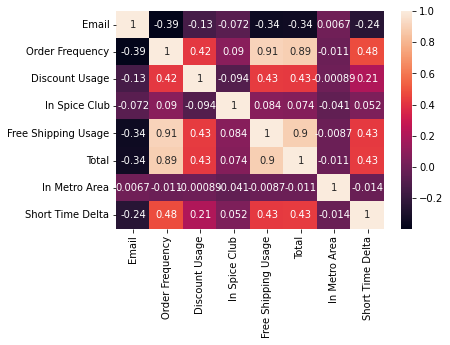

In [ ]:
import seaborn as sns
sns.heatmap(customer.corr(), annot = True);

We make a couple more imports to libraries relating to classifer ML models.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)

We create a new column called "Repeat Customer". We iterate through the customer dataframe seeing if entries' "Order Frequency" exceeds one. If it does, this new column is filled with 1 representing it's a repeat customer otherwise it is filled with 0 representing it's a one-time customer. This new column will be the target of our ML model which means we will try to predict it using the different variables which will be our features. 

In [ ]:
is_repeat_customer = []

for index, row in customer.iterrows():
  if (row['Order Frequency'] > 1):
    is_repeat_customer.append(1)
  else:
    is_repeat_customer.append(0)

customer['Repeat Customer'] = is_repeat_customer

We create a test and train set. The train set will be used to train the ML model, while the test set (which is 20@) of the data will be used to test how well the ML model works. 

In [ ]:
train, test = train_test_split(customer, test_size = 0.2, stratify = customer['Repeat Customer'], random_state = 42)

In [ ]:
customer.columns

Index(['Email', 'Order Frequency', 'Discount Usage', 'In Spice Club',
       'Free Shipping Usage', 'Total', 'Zip Code', 'City', 'State',
       'In Metro Area', 'Short Time Delta', 'Repeat Customer'],
      dtype='object')

As we previously mentioned, the different variables (Discount Usage, In Spice Club, Free Shipping Usage, In Metro Area, Short Time Delta) are the features which can be used to predict the target which is whether or not the customer is a Repeat Customer. 

In [ ]:
fn = ['Discount Usage', 'In Spice Club', 'Free Shipping Usage', 'In Metro Area', 'Short Time Delta']
cn = ['Repeat Customer']

In [ ]:
x_train = train[fn]
y_train = train[cn]
x_test = test[fn]
y_test = test[cn]

We then create a Logistic Rregression classifier which is trained by the X_train and y_train set, which is the parameters of the classifier. We print the statistical summary of the logistic regression.

In [ ]:
LogisticModel = sm.Logit(y_train, x_train).fit()
print(LogisticModel.summary())

         Current function value: 0.421091
         Iterations: 35


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:        Repeat Customer   No. Observations:                41100
Model:                          Logit   Df Residuals:                    41095
Method:                           MLE   Df Model:                            4
Date:                Thu, 08 Dec 2022   Pseudo R-squ.:                  0.3498
Time:                        00:10:17   Log-Likelihood:                -17307.
converged:                      False   LL-Null:                       -26618.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Discount Usage         -0.6096      0.031    -19.357      0.000      -0.671      -0.548
In Spice Club          -1.6769      0.023    -71.793      0.000      -1.723      -1.631
Free Shipping Us

The logistic regression creates a function which can be used to predict y-values (y_hat) using x-values (x_test). y_hat which is the predictions is compared to the actual y_test set.

In [ ]:
y_hat = LogisticModel.predict(x_test)
compare = pd.concat([y_test, y_hat], axis=1)
compare = compare.rename(columns={0: 'y_hat'})
compare['difference'] = compare['Repeat Customer'] - compare['y_hat']
compare.sort_values(by=['difference'])

,Repeat Customer,y_hat,difference
43394,0,0.722856,-0.722856
43156,0,0.722856,-0.722856
31366,0,0.722856,-0.722856
28793,0,0.722856,-0.722856
20913,0,0.722856,-0.722856
...,...,...,...
9046,1,0.025956,0.974044
10722,1,0.020123,0.979877
2054,1,0.014278,0.985722
23980,1,0.014278,0.985722


We create a confusion matrix and calculate the accuracy score by oomparing the y_test values versus the prediction values. The confusion matrix calculates the number of true positives, false positives, true negatives, and false negatives while the accuracy calculates which is a score of the number of correct predictions. There's a high accuracy on the test, which suggests this is a well-fit model for the dataset. 

In [ ]:
prediction = list(map(round, y_hat)) 

# confusion matrix 
cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[5812  864]
 [ 929 2671]]
Test accuracy =  0.8255157648890619


# Answering: How does discount usage affect order frequency?

We create a varriety of plots which emphasize the relationship between order frequency and discount usage. 

We begin by plotting a scatter plot using the Discount Usage and Order Frequency column from the customer dataframe. Again, we see a fairly strong linear relationship.

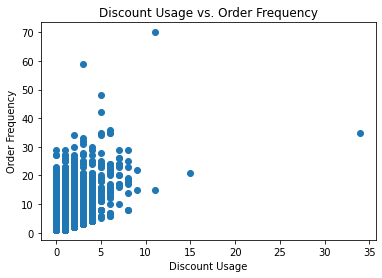

In [ ]:
plt.scatter(customer['Discount Usage'], customer['Order Frequency'])
plt.xlabel('Discount Usage')
plt.ylabel('Order Frequency')
plt.title('Discount Usage vs. Order Frequency')
plt.show()

In [ ]:
discount_df = data.copy()
discount_df = discount_df.drop(['Name', 'Email', 'Financial Status', 'Fulfillment Status',
       'Fulfilled at', 'Accepts Marketing', 'Currency', 'Subtotal', 'Shipping',
       'Taxes', 'Total', 'Discount Code', 'Shipping Method',
       'Created at', 'Lineitem quantity', 'Lineitem name', 'Lineitem price',
       'Lineitem compare at price', 'Lineitem sku',
       'Lineitem requires shipping', 'Lineitem taxable',
       'Lineitem fulfillment status', 'Billing City', 'Billing Zip',
       'Billing Province', 'Billing Country', 'Shipping City', 'Shipping Zip',
       'Shipping Province', 'Shipping Country', 'Cancelled at'], axis = 1)

In [ ]:
total_df = data.copy()
total_df = total_df.drop(['Name', 'Email', 'Financial Status','Fulfillment Status',
       'Fulfilled at', 'Accepts Marketing', 'Currency', 'Subtotal', 'Shipping',
       'Taxes', 'Discount Code', 'Discount Amount', 'Shipping Method',
       'Created at', 'Lineitem quantity', 'Lineitem name', 'Lineitem price',
       'Lineitem compare at price', 'Lineitem sku',
       'Lineitem requires shipping', 'Lineitem taxable',
       'Lineitem fulfillment status', 'Billing City', 'Billing Zip',
       'Billing Province', 'Billing Country', 'Shipping City', 'Shipping Zip',
       'Shipping Province', 'Shipping Country', 'Cancelled at'], axis = 1)

We do a group_by to find the Discount Amount and Total Amount grouped by month for the past two years. We then plot the Discount Amount and Total Amount per month against the months and we find that peaks in Discount Amount parallel peaks in Total Amount which suggests a positive relationship between Discount Amount and Total Amount. 

In [ ]:
summed_discount = discount_df.groupby(['Paid at'])['Discount Amount'].sum()
summed_total = total_df.groupby(['Paid at'])['Total'].sum()

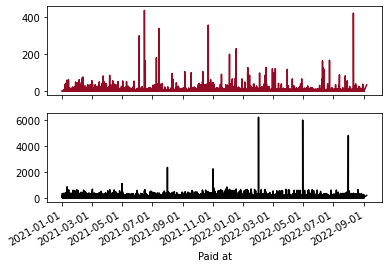

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pylab as plt

plt.subplot(211)
ax = summed_discount.plot(color = '#930c25')
plt.plot()
# plt.title('Discount Amount Over Time')
# plt.xlabel('Time')
# plt.ylabel('Summed Discount Amount (per day)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.subplot(212)
ax1 = (summed_total[summed_total < 9000]).plot(color = '#000')
# plt.title('Revenue Over Time')
# plt.xlabel('Time')
# plt.ylabel('Revenue (per day)')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()

We determine what percent of the total amount is the discount amount and plot this discount percentage on a histogram. 

In [ ]:
discount_pct = []

for index, row in data.iterrows():
  discount_pct.append((row['Discount Amount'] / row['Total']) * 100)

data['Discount Percent'] = discount_pct

In [ ]:
data = data.loc[data['Discount Amount'] < data['Total']]

Text(0, 0.5, 'Frequency')

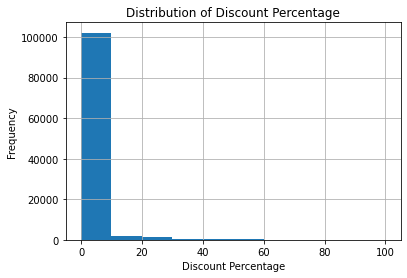

In [ ]:
data['Discount Percent'].hist()
plt.title('Distribution of Discount Percentage')
plt.xlabel('Discount Percentage')
plt.ylabel('Frequency')

We found the number of times the discount percentage exceed 10% which is the the profit margin suggested by Ori. We found 36% of orders which used discounts exceeded the profit margin, which means they are technically losing money on those orders. However, those orders might yield more money in the long-term. 

In [ ]:
count_usage = 0
count_above_10 = 0

for index, row in data.iterrows():
  if (row['Discount Percent'] > 0):
    count_usage += 1
  if (row['Discount Percent'] > 10):
   count_above_10 += 1

print("Of all the times discount is used, " + str((count_above_10/count_usage) * 100) + "% of the time B&B is losing money.")

Of all the times discount is used, 36.42789820923657% of the time B&B is losing money.


# Answering: How does free shipping usage affect order frequency?

We create a variety of plots which emphasize the relationship between order frequency and free shipping usage. 

We begin by plotting a scatter plot using the Free Shipping Usage and Order Frequency column from the customer dataframe. We see an even stronger linear relationship.

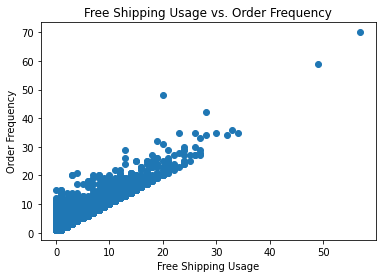

In [ ]:
plt.scatter(customer['Free Shipping Usage'], customer['Order Frequency'])
plt.xlabel('Free Shipping Usage')
plt.ylabel('Order Frequency')
plt.title('Free Shipping Usage vs. Order Frequency')
plt.show()

We creaa new dataframe called loyal_cusstomer which stores the customers whose order frequency exceeded two because those customers are loyal/repeat customers. 

In [ ]:
loyal_customer = customer.loc[customer['Order Frequency'] >= 2]
loyal_email = set(loyal_customer['Email'])

We iterated through this new dataframe creating a dictionary whose keys are the individual customers and whose values is a list of amounts they paid on shipping.

In [ ]:
shipping_amount = defaultdict(list)

for index, row in data.iterrows(): 
  if (row['Email'] in loyal_email):
    shipping_amount[row['Email']].append(row['Shipping'])

print(shipping_amount)

defaultdict(<class 'list'>, {1459.0: [0.0, 5.99], 1460.0: [0.0, 0.0, 0.0, 5.99, 0.0, 0.0, 0.0, 0.0, 0.0], 1461.0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.99, 5.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1462.0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1463.0: [5.99, 0.0, 5.99, 0.0, 5.99], 1464.0: [5.99, 0.0, 0.0, 5.99, 0.0, 7.99, 0.0, 7.99], 1465.0: [5.99, 5.99, 0.0], 1466.0: [0.0, 5.99, 0.0, 0.0, 7.99, 7.99, 7.99], 1467.0: [0.0, 0.0, 0.0, 0.0, 0.0], 1468.0: [0.0, 0.0, 0.0, 0.0, 0.0], 1469.0: [5.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1470.0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.99, 0.0, 0.0], 1471.0: [0.0, 0.0], 1472.0: [0.0, 0.0, 0.0, 0.0, 0.0], 1094.0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1473.0: [5.99, 0.0], 1474.0: [0.0, 7.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.99], 1475.0: [0.0, 5.99, 5.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.99, 7.99, 0.0, 0.0, 0.0, 0.0, 

We then iterate through the dictionary increasing a count of the number of customers whose value list's first element is zero, meaning they used free shipping on their first order. We then calculated of customers who used free shipping on their first order by dividing that count by the number of repeat customers (which is technically the size of the shipping_amount dictionary). We found that 68% of repeat customers used free shipping on their first order. We also plot this on a pie-chart for easy visualization.

In [ ]:
free_shipping_count = 0
for key in shipping_amount:
  if (shipping_amount[key][0] == 0):
    free_shipping_count += 1

print("Of all repeat customers " + str((free_shipping_count) / len(shipping_amount) * 100) + "% of them used free shipping in their first order.")

Of all repeat customers 68.22803800633439% of them used free shipping in their first order.


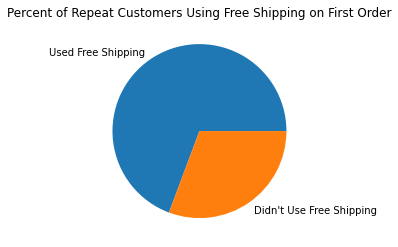

In [ ]:
y = np.array([69.30043896204923, 30.699561038])
mylabels = ["Used Free Shipping", "Didn't Use Free Shipping"]

plt.pie(y, labels = mylabels)
plt.title("Percent of Repeat Customers Using Free Shipping on First Order")
plt.show() 

# Answering: How does location usage affect order frequency?

We create a variety of plots which emphasize the relationship between order frequency and location. 

We begin by finding the percent of repeat customers who live in metro areas verus non-metro areas. We calculate the frequency of customers in the loyal_customer dataframe whose "In-metro" value is 1 suggesting they're in a metro area. About 42$ of repeat customers are from metro areas. 

In [ ]:
loyal_customer['In Metro Area'].value_counts()

0    10400
1     7598
Name: In Metro Area, dtype: int64

In [ ]:
print("Of all repeat customers " + str((7568) / (7568 + 10430) * 100) + "% of them live in a metropolitan area.")

Of all repeat customers 42.049116568507614% of them live in a metropolitan area.


We find the states with the highest frequncy of orders. 

In [ ]:
data['Shipping Province'].value_counts()[:5]

CA    18750
NY    13468
WA     5239
TX     4687
MA     4563
Name: Shipping Province, dtype: int64

In [ ]:
customer

,Email,Order Frequency,Discount Usage,In Spice Club,Free Shipping Usage,Total,Zip Code,City,State,In Metro Area,Short Time Delta,Repeat Customer
0,1459.0,2,0,1,1,87.90,43560,Sylvania,OH,0,0,1
1,1460.0,9,1,1,8,794.77,98230,Blaine,WA,0,1,1
2,1461.0,21,1,1,19,980.51,29650,Greer,SC,0,1,1
3,1462.0,18,1,1,17,1294.04,98103,Seattle,WA,1,1,1
4,1463.0,5,0,0,2,195.61,98948,Toppenish,WA,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
51371,18878.0,1,0,1,1,67.93,78666,San Marcos,TX,0,0,0
51372,18880.0,1,0,0,1,45.00,44663,New Philadelphia,OH,0,0,0
51373,18881.0,1,0,0,0,18.23,20176,Leesburg,VA,0,0,0
51374,18882.0,1,0,1,1,127.99,18901,Doylestown,PA,0,0,0


We trim the customer dataset to be a random sample (yet representative) of 5,000 because it's difficult to plot all 51k customers on a map, since this requires about 51k queries. Additionally, having 51k customers on the plot may also make the map look too clustered that any observations can even be made. 

In [ ]:
chosen_idx = np.random.choice(len(customer), replace=False, size=5000)
customer_trimmed = customer.iloc[chosen_idx]
customer_trimmed

,Email,Order Frequency,Discount Usage,In Spice Club,Free Shipping Usage,Total,Zip Code,City,State,In Metro Area,Short Time Delta,Repeat Customer
35949,30357.0,2,0,1,2,119.95,20817,Bethesda,MD,0,1,1
44824,48653.0,1,0,0,1,59.98,03275,Allenstown,NH,0,0,0
13484,22086.0,1,0,1,1,51.94,60148,Lombard,IL,0,0,0
42628,37028.0,1,0,0,1,59.94,12477,Saugerties,NY,0,0,0
26397,45853.0,1,0,1,1,52.94,75019,Coppell,TX,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6179,7635.0,5,0,0,4,218.91,91311,Chatsworth,CA,0,0,1
47320,51116.0,1,1,1,1,109.98,97080,Gresham,OR,0,0,0
35719,30138.0,1,1,1,1,62.94,11238,Brooklyn,NY,0,0,0
49894,15182.0,1,1,0,1,53.32,22947,Keswick,VA,0,0,0


In [ ]:
customer.dtypes

Email                  float64
Order Frequency          int64
Discount Usage           int64
In Spice Club            int64
Free Shipping Usage      int64
Total                  float64
Zip Code                object
City                    object
State                   object
In Metro Area            int64
Short Time Delta         int64
Repeat Customer          int64
dtype: object

We find the latitutde and longitude of the different customer's zipcode using the zipToLatLon function and pgeocode, a GPS/GIS library, modules. Using the customer's latitudes and longitudes we are able to find all of the cities' latitudes and longitudes. We plot all of these latitutdes and longitudes where the black dots are the customers and the red dots are metropolitan areas.

In [ ]:
%%time

nomi = pgeocode.Nominatim('us')
cache = {"an": None}

def zipToLatLon(postalcode):
    if postalcode in cache:
      return cache[postalcode]

    cache[postalcode] = nomi.query_postal_code(postalcode)
    return cache[postalcode]

lat = []
lon = []
color = []

for _, row in customer_trimmed.iterrows():
  result = zipToLatLon(row["Zip Code"])
  currLat = None
  currLon = None
  if result is not None and not math.isnan(result["latitude"]):
    currLat = result["latitude"]
    currLon = result["longitude"]
  
  lat.append(currLat)
  lon.append(currLon)
  color.append("#000000")

city_zip = {}
for _, row in customer.iterrows():
  city_zip[row["City"]] = row["Zip Code"]
print(city_zip)

for city_name in city_names:
  if city_name in city_zip:
    result = zipToLatLon(city_zip[city_name])
    currLat = None
    currLon = None
    if result is not None and not math.isnan(result["latitude"]):
      currLat = result["latitude"]
      currLon = result["longitude"]
    
    lat.append(currLat)
    lon.append(currLon)
    color.append("#930c25")

{'Sylvania': '43560', 'Blaine': '98230', 'Greer': '29650', 'Seattle': '98105', 'Toppenish': '98948', 'West Miami': '33144', 'Arvada': '80002', 'San Diego': '92109', 'Florence': '35634', 'Milton': '30004', 'Wauwatosa': '53225', 'Eugene': '97405', 'Kensington': '94708', 'Takoma Park': '20912', 'Oak Park': '91377', 'New York': '10024', 'Rio': '53960', 'Sherrills Ford': '28673', 'Williston': '05495', 'Plattsburgh': '12901', 'Woodhaven': '11421', 'The Woodlands': '77381', 'Holden': '04429', 'Kilgore': '75662', 'Gilford': '03249', 'Brooklyn': '11238', 'Palo Alto': '94301', 'Greenwood': '29649', 'Winterport': '04496', 'Anaheim': '92801', 'Cincinnati': '45227', 'Napa': '94558', 'East Brunswick': '08816', 'Peoria': '61603', 'Fullerton': '92832', 'Bloomington': '47401', 'Anchorage': '99507', 'Silver Spring': '20902', 'Woodstock': '12498', 'New Hope': '18938', 'Altadena': '91001', 'Salt Lake City': '84103', 'Goose Creek': '29445', 'North Chesterfield ': '23235', 'Carlisle': '17013', 'Cambria': '9

In [ ]:
# ["#000000", "#930c25"]
fig = px.scatter_geo(lat=lat,lon=lon, color=color, color_discrete_map="identity")
fig.show()